# Sensitivity Analysis (citlivostní analýza)

This tutorial goes through necesarry steps in order to do "sensitivity analysis" of the model. The example model here is cardiovascular hemodynamics controlled by Baroreflex.

This is jupyter notebook, with text-cells and code-cells with python code. 

You can run the code cells and execute Python or any other language scripts there by pressing `Shift-Enter`.

There are Ellipsis in the code `...` which means you need edit the cell and place some correct value,parameter,identifier based on the task.



## 1. Install PyFmi and SALib
You need to import pyfmi library in order to simulate models in FMU from Python. If the following command doesn't produce any error you may continue. If error happens, you need to install pyfmi, e.g. `conda install -c conda-forge pyfmi`.

From section 4 you need to import SALib library in order to use advanced routines available for sensitivity analysis. You need to install using `pip install SALib`. Don't use `conda install ...` as it install old incompatible library.


In [1]:
from pyfmi import load_fmu


## 2. Load model and define basic routines

We will work with model of Hemodynamics of Cardiovascular system per Meurs, with original parameter names:
`EETHV` elastance of extrathoracic veins `EITHV` elastance of intrathoracic veins `EETHA` elastance of extrathoracic arteries `EITHA` elastance of intrathoracic arteries, `RETHA` and `RETHV` resistance of extrathoracic arteries and veins.

[1] J. A. Goodwin, W. L. van Meurs, C. D. S a Couto, J. E. W. Beneken, S. A. Graves, A Model for Educational Simulation of Infant Cardiovascular Physiology, Anesthesia & Analgesia 99 (6) (2004) 1655–1664. doi:10.1213/01.ANE.0000134797.52793.AF.

In [2]:
#Load FMU 
# for linux use MOS2016FMI_HemodynamicsMU.linux.fmu
# for windows use MOS2016FMI_HemodynamicsMU.win.fmu
model = load_fmu('MOS2016FMI_HemodynamicsMU.linux.fmu')

In [3]:
#set number of simulation points
opts = model.simulate_options()
opts['ncp']=600


In [4]:

def simulate_relative(param_name,param_defaultvalue,relvc=1,sopts=opts):
    model.reset()
    #model.instantiate() # needs to ba called in FMU 2.0 from openmodelica, not implemented in FMU 1.0 Dymola
    model.initialize()
    model.reset()
    #param_name = 'Eithv.Elastance'
    #value = 2426467.450953 
    model.set(param_name,relvc*param_defaultvalue)
    res = model.simulate(final_time=20,options = sopts) # 2.1 replace ... with 3 days recalculated in seconds
    return res

def simulate_relativeeithv(relvc=1,sopts=opts):
    return simulate_relative('Eithv.Elastance',2426467.450953,relvc)

def simulate_relativeeethv(relvc=1,sopts=opts):    
    return simulate_relative('Eethv.Elastance',2253148.3473135,relvc)

def simulate_relativeeitha(relvc=1,sopts=opts):
    return simulate_relative('Eitha.Elastance',190651014.00345,relvc)

def simulate_relativeeetha(relvc=1,sopts=opts):    
    return simulate_relative('Eetha.Elastance',74127247.40274,relvc)

def simulate_relativeretha(relvc=1,sopts=opts):
    return simulate_relative('Retha.Resistance',7999343.2449,relvc)

def simulate_relativerethv(relvc=1,sopts=opts):
    return simulate_relative('Rethv.Resistance',11999014.86735,relvc)

# Task 2.1 find some other relevant parameter which may influence mean arterial pressure

In [5]:
r1=simulate_relativeeetha(1)

In [6]:
def plot(x,y,z=None):
    %matplotlib inline
    import matplotlib.pyplot as plt
    fig = plt.figure()
    plt.plot(x,y,'r')
    if z is not None:
        plt.plot(x,z,'b')
    plt.show()

12791.148663992843


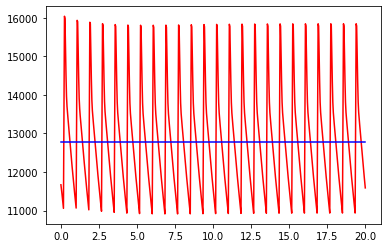

In [7]:
import numpy
mean = numpy.mean(r1['Eitha.q_in.pressure'])
print(mean)
plot(r1['time'],r1['Eitha.q_in.pressure'],numpy.full(r1['time'].size,mean))

In [16]:
r2=simulate_relativeeetha(0.1)

In [19]:
# define function to compute mean from part of the array
def compute_mean(res,part=2):
    last_part = res['Eitha.q_in.pressure'].size// part * (part-1) 
    # we do not want mean value when simulation is not steady - first half of simulation
    mean = numpy.mean(res['Eitha.q_in.pressure'][last_part:]) # take into account last half
    return mean;

# define function to plot the values and mean value
def show_plot_mean(res,part=2):
    mean = compute_mean(res,part)
    print('mean pressure:', mean)
    plot(res['time'],res['Eitha.q_in.pressure'],numpy.full(res['time'].size,mean))
    
# Task define similar functions - but which will show and compute in mmHg

mean pressure: 6766.688303149764


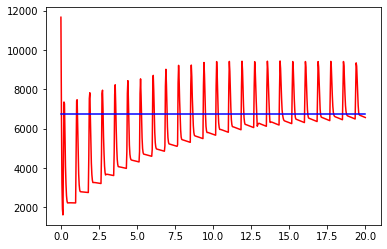

In [20]:
show_plot_mean(r2)

## 2. What is Sensitivity Analysis?

“...the study of how the uncertainty in the output of a mathematical model or system (numerical or otherwise) can be apportioned to different sources of uncertainty in its inputs.”

There are three settings for sensitivity analysis:

    Ranking (factor prioritisation) - which parameters are most influential?
    Screening (factor fixing) - which parameters can we ignore?
    Factor mapping - which inputs matter for just this space in the model output?

There are two types of approaches:

    Local approaches
    Global approaches

And two sampling methods:

    One-at-a-time (OAT)
    All-at-a-time (AAT)

References: 

[1] Pianosi, F., Beven, K., Freer, J., Hall, J. W., Rougier, J., Stephenson, D. B., & Wagener, T. (2016). Sensitivity analysis of environmental models: A systematic review with practical workflow. Environmental Modelling & Software, 79, 214–232. https://doi.org/10.1016/j.envsoft.2016.02.008


### 2.1 Interactive simulation

Find the sliders in the example bellow.



In [21]:
# define function to simulate with multiple parameters set
def simulate_relative_all(param_names,param_defaultvalues,relvc,sopts=opts):
    model.reset()
    #model.instantiate() # needs to ba called in FMU 2.0 from openmodelica, not implemented in FMU 1.0 Dymola
    model.initialize()
    model.reset()
    #param_name = 'Eithv.Elastance'
    #value = 2426467.450953 
    for i in range(0,len(param_names)):
        model.set(param_names[i],relvc[i]*param_defaultvalues[i])
    res = model.simulate(final_time=20,options = sopts) # 2.1 replace ... with 3 days recalculated in seconds
    return res

def simulate_all(eithv=1,eethv=1,eitha=1,eetha=1,retha=1,rethv=1):
    pnames = ['Eithv.Elastance','Eethv.Elastance','Eitha.Elastance','Eetha.Elastance','Retha.Resistance','Rethv.Resistance']
    pdvalues = [2426467.450953,2253148.3473135,190651014.00345,74127247.40274,7999343.2449,11999014.86735]
    relvalues=[eithv,eethv,eitha,eetha,retha,rethv]
    return simulate_relative_all(pnames,pdvalues,relvalues)

In [22]:
#Task 2.1 Which is the most influential parameter for mean arterial pressure? Try interactively.

from ipywidgets import widgets, interact
# lets do OAT interactively
@interact(eithv=widgets.FloatSlider(value=1, min=0.1, max=10, step=0.1, continuous_update=False), 
          eethv=widgets.FloatSlider(value=1, min=0.1, max=10, step=0.1, continuous_update=False),
          eitha=widgets.FloatSlider(value=1, min=0.1, max=10, step=0.1, continuous_update=False),
          eetha=widgets.FloatSlider(value=1, min=0.1, max=10, step=0.1, continuous_update=False),
          retha=widgets.FloatSlider(value=1, min=0.1, max=10, step=0.1, continuous_update=False),
          rethv=widgets.FloatSlider(value=1, min=0.1, max=10, step=0.1, continuous_update=False))
def plot_pressure(eithv: float, eethv: float, eitha: float, eetha: float, retha: float, rethv: float) -> float :
    res = simulate_all(eithv,eethv,eitha,eetha,retha,rethv)
    show_plot_mean(res)
    


interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='eithv', max=10.0, min=0.1),…

## 3.Sensitivity Analysis Techniques 

(adapted from Flechsig (2012), Saltelli(2008))

| Type | Morris | Variance | Factorial | DMIM | Local SA |
|:------|------|------|------|------|------|
|Model independent? | yes | yes | yes | yes | yes|
|Sample source | levels | distributions | levels | distributions | levels |
|No. factors | $20-100^1$ | $<20^1$ | $>100^1$ | $<20$ | $<100$ |
|Factor range | global | global | global | global | local |
|Multi-factor variation | yes | yes | yes | yes | no |
|Correlated factors? | no | no | yes | yes | no |
|Cost (for k factors)? | $10(k+1)$ | $500(k+2)$ | $k \to 2k$ | $500+1$ | $2(k+1)$ |
|Estimated CPU time$^2$ | 1 day | 11 days | 3 hours | ~2 days | 1 hour |
|Best for | Screening | Rank | Screening | Rank | - |
  
[1] using groups of factors would enable larger numbers of factors to be explored
[2] assuming 5 minutes per simulation and 30 groups of factors

### 3.1 Monte carlo simulation

We will randomly select parameter values and run a simulation with these parameters.

In [23]:

def monte_carlo(data):
    y=[]
    for i in range(0,len(data[0])):
        y.append(
            compute_mean(
                simulate_all(data[0][i], data[1][i], data[2][i], data[3][i], data[4][i], data[5][i])
            )
        )
    return y

sims = 1000 # 1000 may take several minutes, 100

# Make random data in the correct ranges
eithv = numpy.random.uniform(0.1, 1, sims)
eethv = numpy.random.uniform(0.1, 1, sims)
eitha = numpy.random.uniform(0.1, 1, sims)
eetha = numpy.random.uniform(0.1, 1, sims)
retha = numpy.random.uniform(0.1, 1, sims)
rethv = numpy.random.uniform(0.1, 1, sims)

data = numpy.array((eithv,eethv,eitha,eetha,retha,rethv))

# Run the monte carlo simulation
y = monte_carlo(data)

### 3.2 Scatter plots

Scatter plots can tell you quite a lot about the relationship between the model inputs and outputs.

Each of the scatter plots shows all the model outputs on the y-axis, but re-ordered by the relationship to the input variable (on the x-axis).

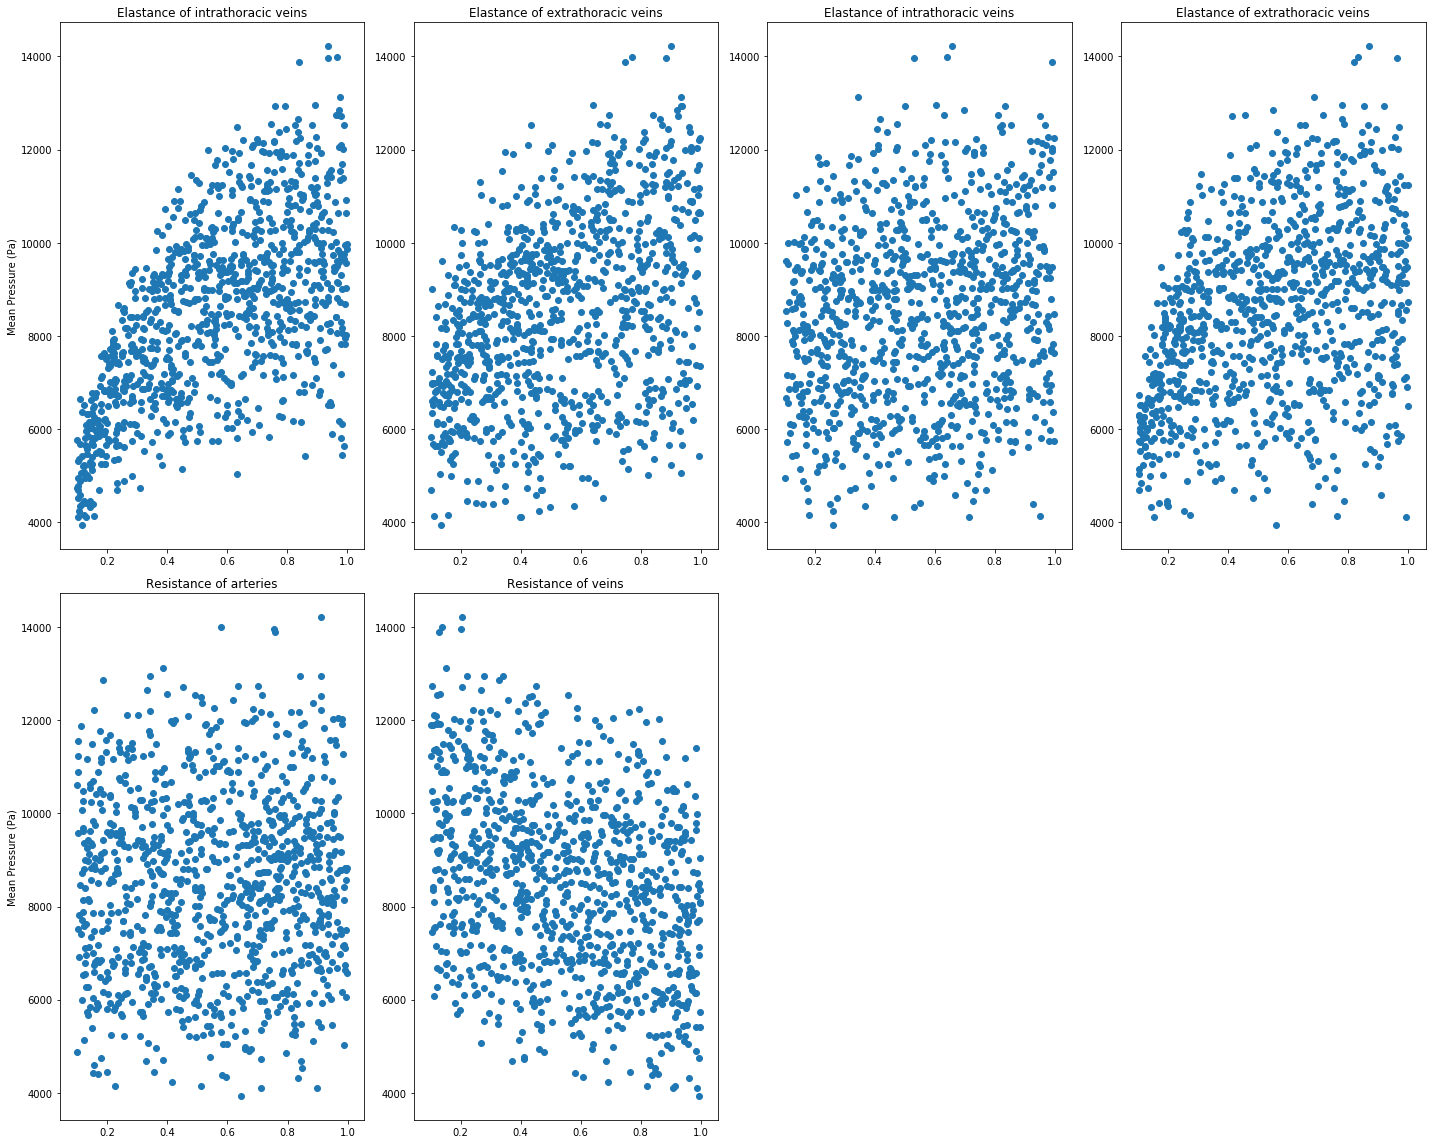

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.core.pylabtools import figsize
figsize(20, 16)

# Make some scatter plots to compare the results
plt.subplot(241)
plt.scatter(eithv, y)
plt.title("Elastance of intrathoracic veins")
plt.ylabel("Mean Pressure (Pa)")
plt.subplot(242)
plt.scatter(eethv, y)
plt.title("Elastance of extrathoracic veins")

plt.subplot(243)
plt.scatter(eitha, y)
plt.title("Elastance of intrathoracic veins")

plt.subplot(244)
plt.scatter(eetha, y)
plt.title("Elastance of extrathoracic veins")

plt.subplot(245)
plt.scatter(retha, y)
plt.title("Resistance of arteries")
plt.ylabel("Mean Pressure (Pa)")
plt.subplot(246)
plt.scatter(rethv, y)
plt.title("Resistance of veins")

plt.tight_layout()

### 3.3 Histogram of values

We can see how often a particular value shows in a results, i.e. histogram of values.

Text(0, 0.5, 'Frequency')

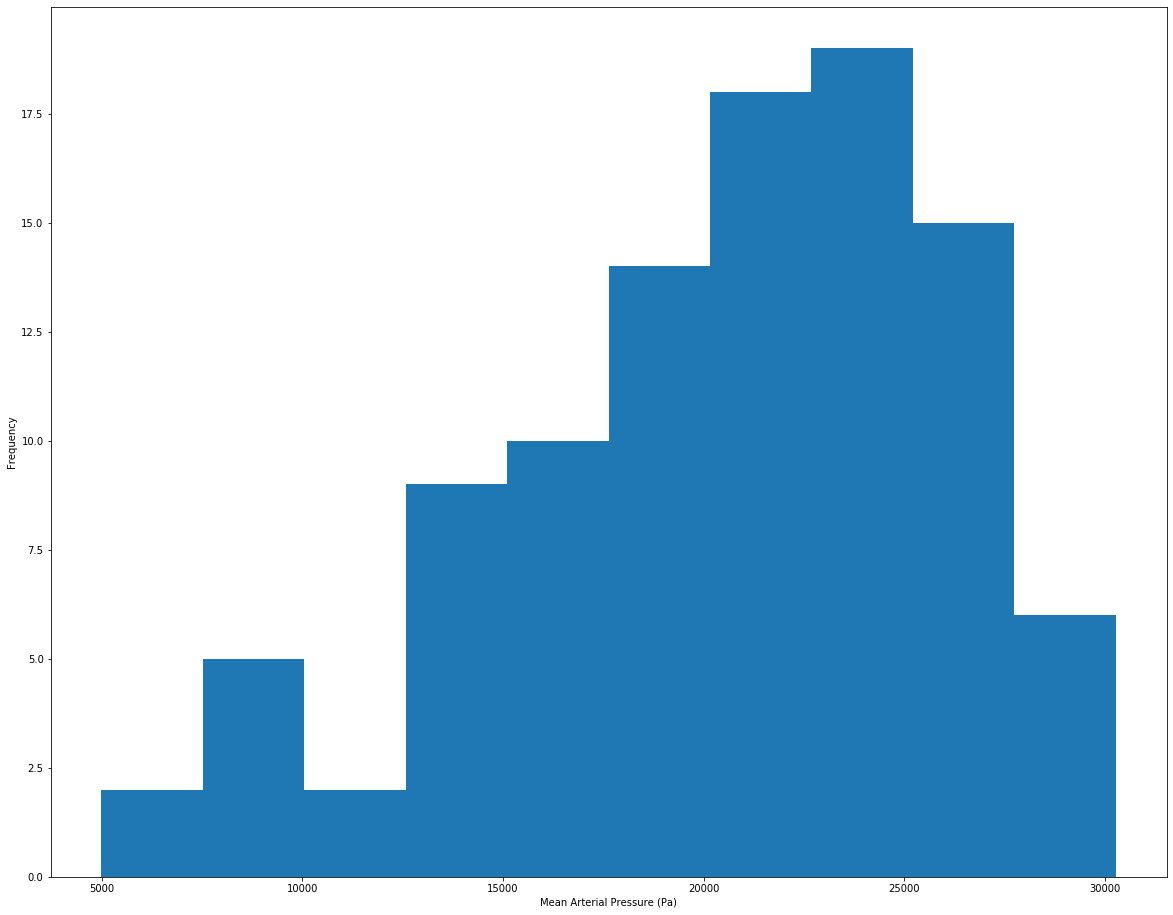

In [17]:
plt.hist(y)
plt.xlabel("Mean Arterial Pressure (Pa)")
plt.ylabel("Frequency")

## 4. Sensitivity analysis using SALib

SALib is a **free** **open-source** **Python** library, you can install it by running the command

```python
pip install SALib
```

[Documentation](http://salib.readthedocs.org/) is available online and you can also view the code on [Github](http://salib.github.io/SALib/).

The library includes:
* Sobol Sensitivity Analysis ([Sobol 2001](http://www.sciencedirect.com/science/article/pii/S0378475400002706), [Saltelli 2002](http://www.sciencedirect.com/science/article/pii/S0010465502002801), [Saltelli et al. 2010](http://www.sciencedirect.com/science/article/pii/S0010465509003087))
* Method of Morris, including groups and optimal trajectories ([Morris 1991](http://www.tandfonline.com/doi/abs/10.1080/00401706.1991.10484804), [Campolongo et al. 2007](http://www.sciencedirect.com/science/article/pii/S1364815206002805))
* Fourier Amplitude Sensitivity Test (FAST) ([Cukier et al. 1973](http://scitation.aip.org/content/aip/journal/jcp/59/8/10.1063/1.1680571), [Saltelli et al. 1999](http://amstat.tandfonline.com/doi/abs/10.1080/00401706.1999.10485594))
* Delta Moment-Independent Measure ([Borgonovo 2007](http://www.sciencedirect.com/science/article/pii/S0951832006000883), [Plischke et al. 2013](http://www.sciencedirect.com/science/article/pii/S0377221712008995))
* Derivative-based Global Sensitivity Measure (DGSM) ([Sobol and Kucherenko 2009](http://www.sciencedirect.com/science/article/pii/S0378475409000354))
* Fractional Factorial Sensitivity Analysis ([Saltelli et al. 2008](http://www.wiley.com/WileyCDA/WileyTitle/productCd-0470059974.html))

In [18]:
from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp

In [19]:
# define a problem
morris_problem = {
    # There are n variables
    'num_vars': 6,
    # These are their names
    'names': ['eithv', 'eethv', 'eitha', 'eetha', 
              'retha', 'rethv'],
    # Plausible ranges over which we'll move the variables
    'bounds': [[0.1, 1], # eithv
               [0.1, 1], 
               [0.1, 1], 
               [0.1, 1], 
               [0.1, 1], 
               [0.1, 1]
               
                         
              ],
    # I don't want to group any of these variables together
    'groups': None
    }

In [20]:
number_of_trajectories = 10
sample = ms.sample(morris_problem, number_of_trajectories, num_levels=4)

### Ranking

We'll run a sensitivity analysis of the power module to see which is the most influential parameter.

The results parameters are called **mu**, **sigma** and **mu_star**.

* **Mu** is the mean effect caused by the input parameter being moved over its range.
* **Sigma** is the standard deviation of the mean effect.
* **Mu_star** is the mean absolute effect.

In [21]:
# Run the sample through the monte carlo procedure of the power model
# Task 4.1 uncomment and run sensitivity analysis - it may take time
output = monte_carlo(sample.T)


In [23]:
# Store the results for plotting of the analysis
Si = ma.analyze(morris_problem, sample, numpy.array(output), print_to_console=False)
print("{:20s} {:>7s} {:>7s} {:>7s}".format("Name", "mu", "mu_star", "sigma"))
for name, s1, st, mean in zip(morris_problem['names'], 
                              Si['mu'], 
                              Si['mu_star'], 
                              Si['sigma']):
    print("{:20s} {:=7.2f} {:=7.2f} {:=7.2f}".format(name, s1, st, mean))

Name                      mu mu_star   sigma
eithv                7072.27 7125.78 8788.38
eethv                7997.36 7997.36 9105.70
eitha                4093.72 4506.20 7933.10
eetha                4403.37 4737.79 7075.13
retha                3468.49 3468.49 2186.82
rethv                -1802.37 3833.00 4117.65


Now, plot the results in 

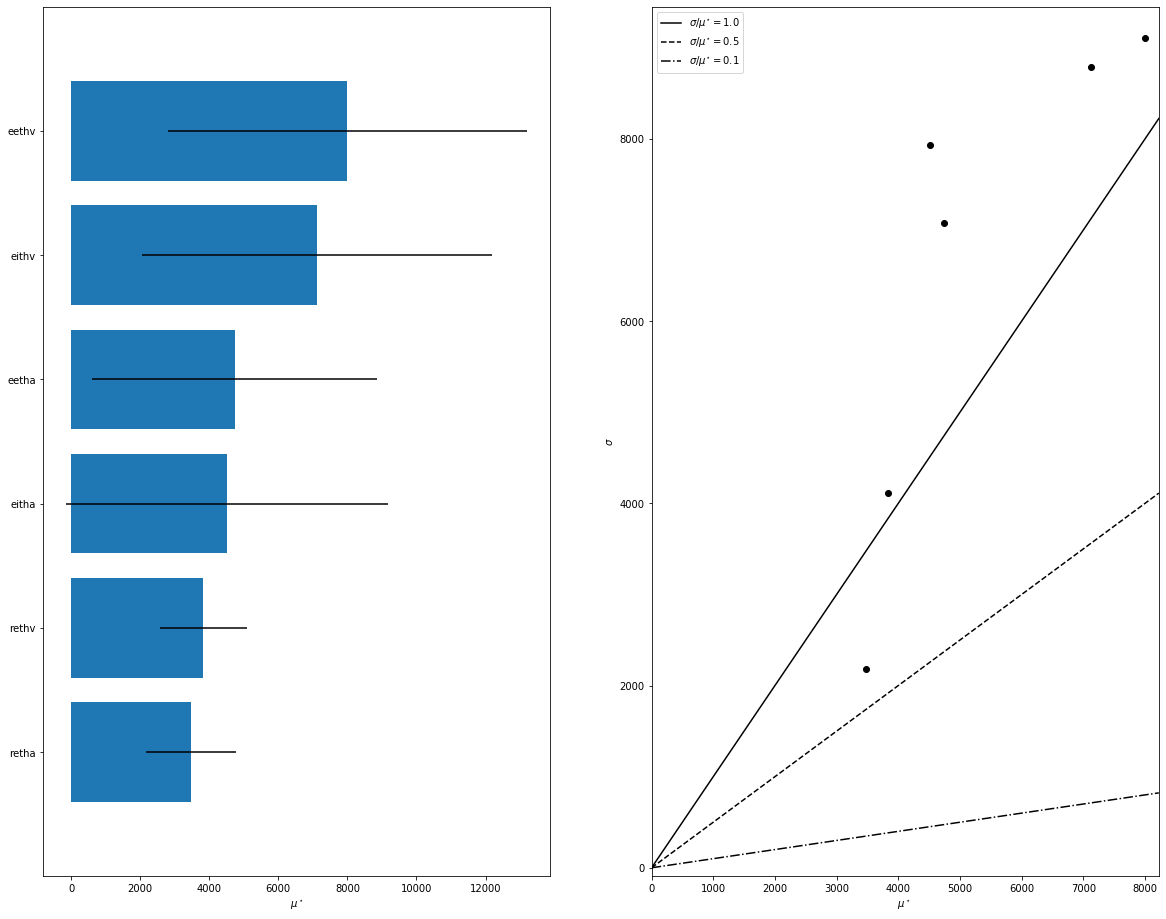

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2)
mp.horizontal_bar_plot(ax1, Si, {})
mp.covariance_plot(ax2, Si, {})

SALib at http://github.com/SALib/SALib
Similar packages to SALib for other languages/programmes:

    Matlab Toolbox SAFE for GSA
    sensitivity package for R


## Summary

- installed PyFMI and SALib
- loaded model and defined basic routines to compute mean pressure from simulation
- did monte carlo simulations
- show scatter plot - from monte carlo simulations
- did selected method from SALib

# Assignement 5

define simulateall2

mean pressure: 6074.116212733487


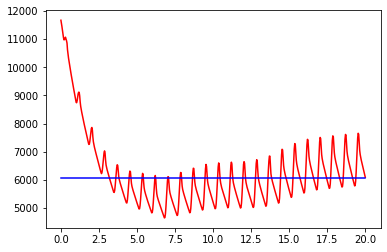

In [48]:
r3= simulate_relative('AorticValve._Ron',1066579.09932,500)
show_plot_mean(r3)

In [25]:
def simulate_all2(eithv=1,eethv=1,eitha=1,eetha=1,retha=1,rethv=1,raov=1,rpv=1):
    pnames = ['Eithv.Elastance','Eethv.Elastance','Eitha.Elastance','Eetha.Elastance','Retha.Resistance','Rethv.Resistance','AorticValve._Ron','PulmonaryValve._Ron']
    pdvalues = [2426467.450953,2253148.3473135,190651014.00345,74127247.40274,7999343.2449,11999014.86735,1066579.09932,399967.162245]
    relvalues=[eithv,eethv,eitha,eetha,retha,rethv,raov,rpv]
    return simulate_relative_all(pnames,pdvalues,relvalues)

In [56]:

def monte_carlo2(data):
    y=[]
    for i in range(0,len(data[0])):
        y.append(
            compute_mean(
                simulate_all2(data[0][i], data[1][i], data[2][i], data[3][i], data[4][i], data[5][i], data[6][i], data[7][i])
            )
        )
    return y

sims = 1000 # 1000 may take several minutes, 100

# Make random data in the correct ranges
eithv = numpy.random.uniform(0.1, 1, sims)
eethv = numpy.random.uniform(0.1, 1, sims)
eitha = numpy.random.uniform(0.1, 1, sims)
eetha = numpy.random.uniform(0.1, 1, sims)
retha = numpy.random.uniform(0.1, 1, sims)
rethv = numpy.random.uniform(0.1, 1, sims)
raov = numpy.random.uniform(1, 500, sims)
rpv = numpy.random.uniform(1, 500, sims)

data = numpy.array((eithv,eethv,eitha,eetha,retha,rethv,raov,rpv))

# Run the monte carlo simulation
y = monte_carlo2(data)

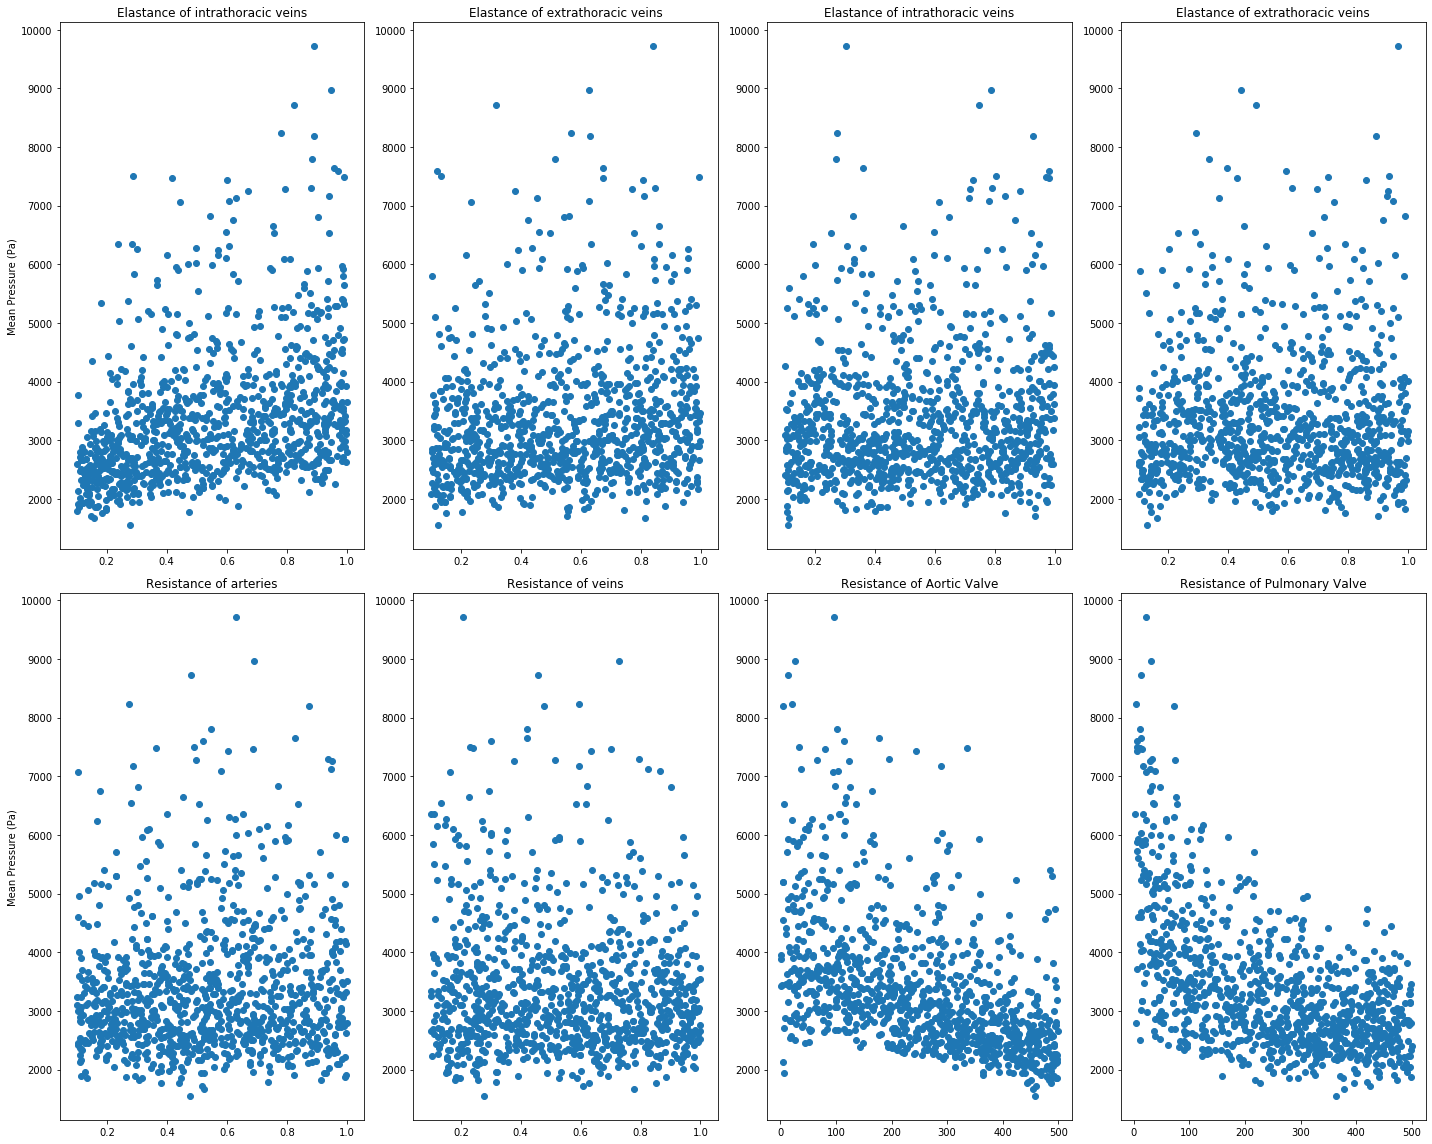

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.core.pylabtools import figsize
figsize(20, 16)

# Make some scatter plots to compare the results
plt.subplot(241)
plt.scatter(eithv, y)
plt.title("Elastance of intrathoracic veins")
plt.ylabel("Mean Pressure (Pa)")
plt.subplot(242)
plt.scatter(eethv, y)
plt.title("Elastance of extrathoracic veins")

plt.subplot(243)
plt.scatter(eitha, y)
plt.title("Elastance of intrathoracic veins")

plt.subplot(244)
plt.scatter(eetha, y)
plt.title("Elastance of extrathoracic veins")

plt.subplot(245)
plt.scatter(retha, y)
plt.title("Resistance of arteries")
plt.ylabel("Mean Pressure (Pa)")
plt.subplot(246)
plt.scatter(rethv, y)
plt.title("Resistance of veins")

plt.subplot(247)
plt.scatter(raov, y)
plt.title("Resistance of Aortic Valve")

plt.subplot(248)
plt.scatter(rpv, y)
plt.title("Resistance of Pulmonary Valve")

plt.tight_layout()

In [51]:
# define a problem
morris_problem = {
    # There are n variables
    'num_vars': 8,
    # These are their names
    'names': ['eithv', 'eethv', 'eitha', 'eetha', 
              'retha', 'rethv','raov','rpv'],
    # Plausible ranges over which we'll move the variables
    'bounds': [[0.1, 1], # eithv
               [0.1, 1], 
               [0.1, 1], 
               [0.1, 1], 
               [0.1, 1], 
               [0.1, 1],
               [1, 500],
               [1, 500]                                        
              ],
    # I don't want to group any of these variables together
    'groups': None
    }

In [52]:
number_of_trajectories = 100
from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp
sample = ms.sample(morris_problem, number_of_trajectories, num_levels=4)

In [53]:
output = monte_carlo2(sample.T)

In [54]:
Si = ma.analyze(morris_problem, sample, numpy.array(output), print_to_console=False)
print("{:20s} {:>7s} {:>7s} {:>7s}".format("Name", "mu", "mu_star", "sigma"))
for name, s1, st, mean in zip(morris_problem['names'], 
                              Si['mu'], 
                              Si['mu_star'], 
                              Si['sigma']):
    print("{:20s} {:=7.2f} {:=7.2f} {:=7.2f}".format(name, s1, st, mean))

Name                      mu mu_star   sigma
eithv                1417.48 1417.48 1485.87
eethv                 876.33  881.46 1092.50
eitha                 374.69  467.94  547.57
eetha                 616.68  780.94 1159.72
retha                  43.10  110.27  140.51
rethv                -241.60  297.22  598.34
raov                 -1963.33 1963.33 1384.50
rpv                  -2128.52 2128.52 2020.56


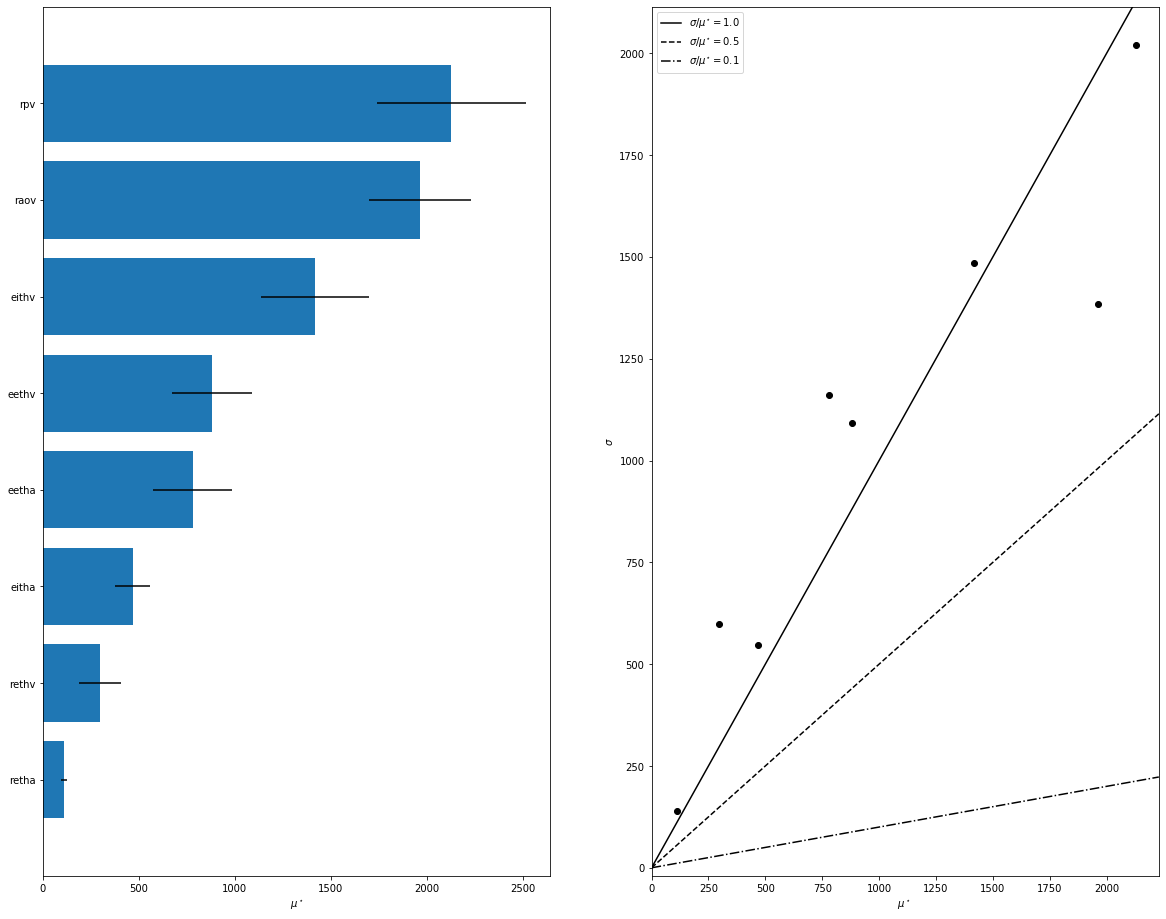

In [55]:
fig, (ax1, ax2) = plt.subplots(1,2)
mp.horizontal_bar_plot(ax1, Si, {})
mp.covariance_plot(ax2, Si, {})